<a href="https://colab.research.google.com/github/CHITHRA-V-H/skills-introduction-to-github/blob/main/PTandTraining_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start by importing necessary packages
You will begin by importing necessary libraries for this notebook. Run the cell below to do so.

# PyTorch and Intro to Training

In [10]:
!pip install thop
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import thop
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


## Checking the torch version and CUDA access
Let's start off by checking the current torch version, and whether you have CUDA availablity.

In [11]:
print("torch is using version:", torch.__version__, "with CUDA=", torch.cuda.is_available())

torch is using version: 2.5.1+cu121 with CUDA= True


By default, you will see CUDA = False, meaning that the Colab session does not have access to a GPU. To remedy this, click the Runtime menu on top and select "Change Runtime Type", then select "T4 GPU".

Re-run the import cell above, and the CUDA version / check. It should show now CUDA = True

Sometimes in Colab you get a message that your Session has crashed, if that happens you need to go to the Runtime menu on top and select "Restart session".

You won't be using the GPU just yet, but this prepares the instance for when you will.

**Please note that the GPU is a scarce resource which may not be available at all time. Additionally, there are also usage limits that you may run into (although not likely for this assignment). When that happens you need to try again later/next day/different time of the day. Another reason to start the assignment early!**

## A Brief Introduction to PyTorch

PyTorch, or torch, is a machine learning framework developed my Facebook AI Research, which competes with TensorFlow, JAX, Caffe and others.

Roughly speaking, these frameworks can be split into dynamic and static defintion frameworks.

**Static Network Definition:** The architecture and computation flow are defined simultaneously. The order and manner in which data flows through the layers are fixed upon definition. These frameworks also tend to declare parameter shapes implicitly via the compute graph. This is typical of TensorFlow and JAX.

**Dynamic Network Definition:** The architecture (layers/modules) is defined independently of the computation flow, often during the object's initialization. This allows for dynamic computation graphs where the flow of data can change during runtime based on conditions. Since the network exists independent of the compute graph, the parameter shapes must be declared explitly. PyTorch follows this approach.

All ML frameworks support automatic differentiation, which is necessary to train a model (i.e. perform back propagation).

Let's consider a typical pytorch module. Such modules will inherit from the torch.nn.Module class, which provides many built in functions such as a wrapper for `__call__`, operations to move the module between devices (e.g. `cuda()`, `cpu()`), data-type conversion (e.g. `half()`, `float()`), and parameter and child management (e.g. `state_dict()`, `parameters()`).

In [12]:
# inherit from torch.nn.Module
class MyModule(nn.Module):
  # constructor called upon creation
  def __init__(self):
    # the module has to initialize the parent first, which is what sets up the wrapper behavior
    super().__init__()

    # we can add sub-modules and parameters by assigning them to self
    self.my_param = nn.Parameter(torch.zeros(4,8)) # this is how you define a raw parameter of shape 4x5
    self.my_sub_module = nn.Linear(8,12)       # this is how you define a linear layer (tensorflow calls them Dense) of shape 8x12

    # we can also add lists of modules, for example, the sequential layer
    self.net = nn.Sequential(  # this layer type takes in a collection of modules rather than a list
        nn.Linear(4,4),
        nn.Linear(4,8),
        nn.Linear(8,12)
    )

    # the above when calling self.net(x), will execute each module in the order they appear in a list
    # it would be equivelent to x = self.net[2](self.net[1](self.net[0](x)))

    # you can also create a list that doesn't execute
    self.net_list = nn.ModuleList([
        nn.Linear(7,7),
        nn.Linear(7,9),
        nn.Linear(9,14)
    ])

    # sometimes you will also see constant variables added to the module post init
    foo = torch.Tensor([4])
    self.register_buffer('foo', foo) # buffers allow .to(device, type) to apply

  # let's define a forward function, which gets executed when calling the module, and defines the forward compute graph
  def forward(self, x):

    # if x is of shape Bx4
    h1 =  x @ self.my_param # tensor-tensor multiplication uses the @ symbol
    # then h1 is now shape Bx8, because my_param is 4x8... 2x4 * 4x8 = 2x8

    h1 = self.my_sub_module(h1) # you execute a sub-module by calling it
    # now, h1 is of shape Bx12, because my_sub_module was a 8x12 matrix

    h2 = self.net(x)
    # similarly, h2 is of shape Bx12, because that's the output of the sequence
    # Bx4 -(4x4)-> Bx4 -(4x8)-> Bx8 -(8x12)-> Bx12

    # since h1 and h2 are the same shape, they can be added together element-wise
    return h1 + h2


Then you can instantiate the module and perform a forward pass by calling it.

In [13]:
# create the module
module = MyModule()

# you can print the module to get a high-level summary of it
print("=== printing the module ===")
print(module)
print()
# notice that the sub-module name is in parenthesis, and so are the list indicies

# let's view the shape of one of the weight tensors
print("my_sub_module weight tensor shape=", module.my_sub_module.weight.shape)
# the above works because nn.Linear has a member called .weight and .bias
# to view the shape of my_param, you would use module.my_param
# and to view the shape of the 2nd elment in net_list, you would use module.net_list[1].weight

# you can iterate through all of the parameters via the state dict
print()
print("=== Listing parameters from the state_dict ===")
for key,value in module.state_dict().items():
  print(f"{key}: {value.shape}")


=== printing the module ===
MyModule(
  (my_sub_module): Linear(in_features=8, out_features=12, bias=True)
  (net): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=12, bias=True)
  )
  (net_list): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=14, bias=True)
  )
)

my_sub_module weight tensor shape= torch.Size([12, 8])

=== Listing parameters from the state_dict ===
my_param: torch.Size([4, 8])
foo: torch.Size([1])
my_sub_module.weight: torch.Size([12, 8])
my_sub_module.bias: torch.Size([12])
net.0.weight: torch.Size([4, 4])
net.0.bias: torch.Size([4])
net.1.weight: torch.Size([8, 4])
net.1.bias: torch.Size([8])
net.2.weight: torch.Size([12, 8])
net.2.bias: torch.Size([12])
net_list.0.weight: torch.Size([7, 7])
net_list.0.bias: torch.Size([7

In [14]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
y = module(x)

# then you can print the result and shape
print(y, y.shape)

tensor([[-0.0357,  0.1723,  0.5191, -0.2647,  0.6385, -0.1052,  0.4070, -0.4632,
          0.2190, -0.0654,  0.0529,  0.3292],
        [-0.0357,  0.1723,  0.5191, -0.2647,  0.6385, -0.1052,  0.4070, -0.4632,
          0.2190, -0.0654,  0.0529,  0.3292]], grad_fn=<AddBackward0>) torch.Size([2, 12])


Please check the cell below to notice the following:

1.   `x` above was created with the shape 2x4, and in the forward pass, it gets manipulated into a 2x12 tensor. This last dimension is explicit, while the first is called the batch dimmension, and only exists on data (a.k.a. activations). The output shape can be seen in the print statement from y.shape
2.   You can view the shape of a tensor by using `.shape`, this is a very helpful trick for debugging tensor shape errors
3.   In the output, there's a `grad_fn` component, this is the hook created by the forward trace to be used in back-propagation via automatic differentiation. The function name is `AddBackward`, because the last operation performed was `h1+h2`.

We might not always want to trace the compute graph though, such as during inference. In such cases, you can use the `torch.no_grad()` context manager.


In [15]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
with torch.no_grad():
  y = module(x)

# then you can print the result and shape
print(y, y.shape)
# notice how the grad_fn is no longer part of the output tensor, that's because not_grad() disables the graph generation

tensor([[-0.0357,  0.1723,  0.5191, -0.2647,  0.6385, -0.1052,  0.4070, -0.4632,
          0.2190, -0.0654,  0.0529,  0.3292],
        [-0.0357,  0.1723,  0.5191, -0.2647,  0.6385, -0.1052,  0.4070, -0.4632,
          0.2190, -0.0654,  0.0529,  0.3292]]) torch.Size([2, 12])


Aside from passing a tensor through a model with the `no_grad()` context, you can also detach a tensor from the compute graph by calling `.detach()`. This will effectively make a copy of the original tensor, which allows it to be converted to numpy and visualized with matplotlib.

**Note:** Tensors with a `grad_fn` property cannot be plotted and must first be detached.

## Multi-Layer-Perceptron (MLP) Prediction of MNIST

With some basics out of the way, let's create a MLP for training MNIST.
You can start by defining a simple torch model.

In [16]:
# Define the MLP model
class MLP(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # the input projection layer - projects into d=128
        self.fc1 = nn.Linear(28*28, 128)
        # the first hidden layer - compresses into d=64
        self.fc2 = nn.Linear(128, 64)
        # the final output layer - splits into 10 classes (digits 0-9)
        self.fc3 = nn.Linear(64, 10)

    # define the forward pass compute graph
    def forward(self, x):
        # x is of shape BxHxW

        # we first need to unroll the 2D image using view
        # we set the first dim to be -1 meanining "everything else", the reason being that x is of shape BxHxW, where B is the batch dim
        # we want to maintain different tensors for each training sample in the batch, which means the output should be of shape BxF where F is the feature dim
        x = x.view(-1, 28*28)
        # x is of shape Bx784

        # project-in and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc1(x))
        # x is of shape Bx128

        # middle-layer and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc2(x))
        # x is of shape Bx64

        # project out into the 10 classes
        x = self.fc3(x)
        # x is of shape Bx10
        return x

Before you can begin training, you have to do a little boiler-plate to load the dataset. From the previous assignment, you saw how a hosted dataset can be loaded with TensorFlow. With pytorch it's a little more complicated, as you need to manually condition the input data.

In [17]:
# define a transformation for the input images. This uses torchvision.transforms, and .Compose will act similarly to nn.Sequential
transform = transforms.Compose([
    transforms.ToTensor(), # first convert to a torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # then normalize the input
])

# let's download the train and test datasets, applying the above transform - this will get saved locally into ./data, which is in the Colab instance
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# we need to set the mini-batch (commonly referred to as "batch"), for now we can use 64
batch_size = 64

# then we need to create a dataloader for the train dataset, and we will also create one for the test dataset to evaluate performance
# additionally, we will set the batch size in the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# the torch dataloaders allow us to access the __getitem__ method, which returns a tuple of (data, label)
# additionally, the dataloader will pre-colate the training samples into the given batch_size


Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 450kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.61MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.26MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Inspect the first element of the test_loader, and verify both the tensor shapes and data types. You can check the data-type with `.dtype`

**Question 1**

Edit the cell below to print out the first element shapes, dtype, and identify which is the training sample and which is the training label.

In [18]:
# Get the first item
first_item = next(iter(test_loader))

# print out the element shapes, dtype, and identify which is the training sample and which is the training label
# MNIST is a supervised learning task




# The first item contains two elements: data (images) and labels
data, labels = first_item

# Print out the shapes and data types
print("Shape of the data (images):", data.shape)  # Should be [batch_size, channels, height, width]
print("Data dtype:", data.dtype)  # Should be torch.float32 after transforms.ToTensor()

print("Shape of the labels:", labels.shape)  # Should be [batch_size]
print("Labels dtype:", labels.dtype)  # Should be torch.int64 (long)

# Identify which is the training sample and which is the training label
print("\nTraining samples are the images, shape:", data.shape)
print("Training labels are the digit class IDs, shape:", labels.shape)


Shape of the data (images): torch.Size([64, 1, 28, 28])
Data dtype: torch.float32
Shape of the labels: torch.Size([64])
Labels dtype: torch.int64

Training samples are the images, shape: torch.Size([64, 1, 28, 28])
Training labels are the digit class IDs, shape: torch.Size([64])


Now that we have the dataset loaded, we can instantiate the MLP model, the loss (or criterion function), and the optimizer for training.

In [19]:
# create the model
model = MLP()

# you can print the model as well, but notice how the activation functions are missing. This is because they were called in the forward pass
# and not declared in the constructor
print(model)

# you can also count the model parameters
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# for a critereon (loss) function, you will use Cross-Entropy Loss. This is the most common criterion used for multi-class prediction,
# and is also used by tokenized transformer models it takes in an un-normalized probability distribution (i.e. without softmax) over
# N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label which is < N.
# For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum
# factor of 0.5. the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model has 109,386 trainable parameters


Finally, you can define a training, and test loop

In [20]:
# create an array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [21]:
# declare the train function
def cpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as
    # batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the
    # iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # then you can apply a forward pass, which includes evaluating the loss (criterion)
        output = model(data)
        loss = criterion(output, target)

        # given that you want to minimize the loss, you need to call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all you have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # you should add some output to the progress bar so that you know which epoch you are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help you evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def cpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for you, but it is needed with other layers like batch_norm
    # and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since you are not training the model, and do not need back-propagation, you can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # like with training, run a forward pass through the model and evaluate the criterion
            output = model(data)
            test_loss += criterion(output, target).item() # you are using .item() to get the loss value rather than the tensor itself

            # you can also check the accuracy by sampling the output - you can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [22]:
# train for 10 epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.299304: 100%|██████████| 938/938 [00:14<00:00, 66.08it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 65.37it/s]



Test set: Average loss: 0.2692, Accuracy: 9219/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.165753: 100%|██████████| 938/938 [00:14<00:00, 65.35it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.05it/s]



Test set: Average loss: 0.1948, Accuracy: 9415/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.229907: 100%|██████████| 938/938 [00:14<00:00, 65.14it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.85it/s]



Test set: Average loss: 0.1663, Accuracy: 9505/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.169193: 100%|██████████| 938/938 [00:14<00:00, 66.87it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 64.46it/s]



Test set: Average loss: 0.1385, Accuracy: 9572/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.161690: 100%|██████████| 938/938 [00:14<00:00, 65.32it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 77.70it/s]



Test set: Average loss: 0.1210, Accuracy: 9643/10000 (96%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.063481: 100%|██████████| 938/938 [00:14<00:00, 66.83it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.50it/s]



Test set: Average loss: 0.1098, Accuracy: 9676/10000 (97%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.087082: 100%|██████████| 938/938 [00:13<00:00, 67.01it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 72.68it/s]



Test set: Average loss: 0.1034, Accuracy: 9696/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.176652: 100%|██████████| 938/938 [00:14<00:00, 63.56it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.57it/s]



Test set: Average loss: 0.0928, Accuracy: 9712/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.042467: 100%|██████████| 938/938 [00:13<00:00, 67.50it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.98it/s]



Test set: Average loss: 0.0895, Accuracy: 9730/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.027942: 100%|██████████| 938/938 [00:14<00:00, 66.73it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.96it/s]


Test set: Average loss: 0.0866, Accuracy: 9725/10000 (97%)



**Question 2**

Using the skills you acquired in the previous assignment edit the cell below to use matplotlib to visualize the loss for training and validation for the first 10 epochs. They should be plotted on the same graph, labeled, and use a log-scale on the y-axis.

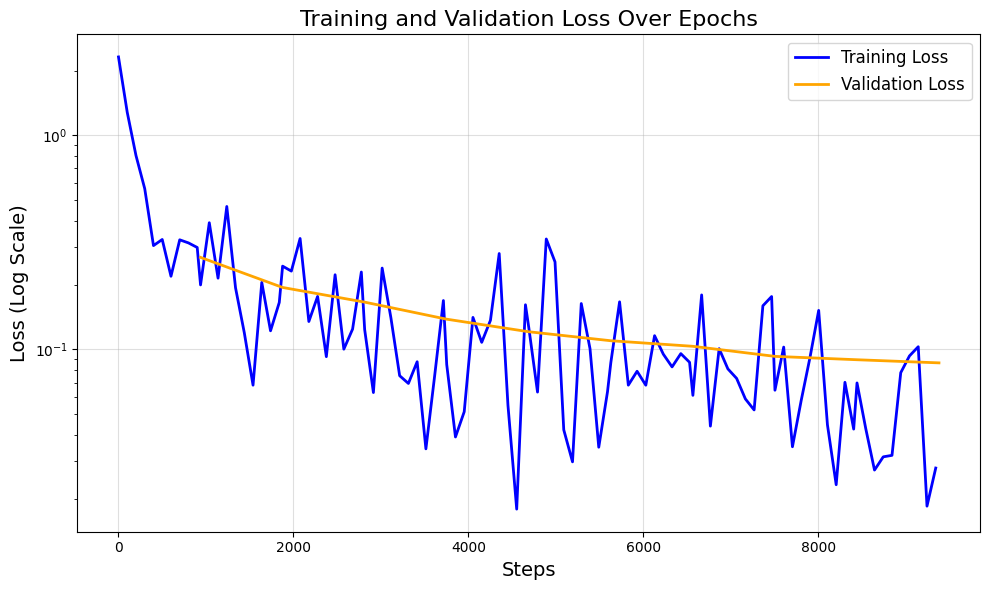

In [23]:
# visualize the losses for the first 10 epochs
import matplotlib.pyplot as plt

# Visualize the loss for training and validation
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_steps, train_losses, label="Training Loss", color='blue', linewidth=2)

# Plot validation loss
plt.plot(test_steps, test_losses, label="Validation Loss", color='orange', linewidth=2)

# Add labels, title, legend, and grid
plt.title("Training and Validation Loss Over Epochs", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss (Log Scale)", fontsize=14)
plt.yscale("log")  # Set log-scale for better visualization
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Display the plot
plt.tight_layout()
plt.show()


**Question 3**

The model may be able to train for a bit longer. Edit the cell below to modify the previous training code to also report the time per epoch and the time for 10 epochs with testing. You can use `time.time()` to get the current time in seconds.
Then run the model for another 10 epochs, printing out the execution time at the end, and replot the loss functions with the extra 10 epochs below.

Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.037416: 100%|██████████| 938/938 [00:14<00:00, 66.67it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 69.21it/s]



Test set: Average loss: 0.0836, Accuracy: 9750/10000 (98%)

Epoch 11 completed in 16.35 seconds.


Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.069433: 100%|██████████| 938/938 [00:14<00:00, 63.53it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.21it/s]



Test set: Average loss: 0.0769, Accuracy: 9763/10000 (98%)

Epoch 12 completed in 16.90 seconds.


Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.009922: 100%|██████████| 938/938 [00:13<00:00, 67.30it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.27it/s]



Test set: Average loss: 0.0756, Accuracy: 9763/10000 (98%)

Epoch 13 completed in 16.01 seconds.


Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.035831: 100%|██████████| 938/938 [00:14<00:00, 66.55it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.55it/s]



Test set: Average loss: 0.0780, Accuracy: 9756/10000 (98%)

Epoch 14 completed in 16.22 seconds.


Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.056023: 100%|██████████| 938/938 [00:14<00:00, 63.96it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.75it/s]



Test set: Average loss: 0.0770, Accuracy: 9757/10000 (98%)

Epoch 15 completed in 16.75 seconds.


Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.122490: 100%|██████████| 938/938 [00:14<00:00, 66.15it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.00it/s]



Test set: Average loss: 0.0738, Accuracy: 9789/10000 (98%)

Epoch 16 completed in 16.29 seconds.


Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.045527: 100%|██████████| 938/938 [00:14<00:00, 66.49it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.00it/s]



Test set: Average loss: 0.0714, Accuracy: 9781/10000 (98%)

Epoch 17 completed in 16.27 seconds.


Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.062909: 100%|██████████| 938/938 [00:14<00:00, 63.32it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.09it/s]



Test set: Average loss: 0.0704, Accuracy: 9776/10000 (98%)

Epoch 18 completed in 16.92 seconds.


Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.009150: 100%|██████████| 938/938 [00:14<00:00, 66.65it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.91it/s]



Test set: Average loss: 0.0713, Accuracy: 9791/10000 (98%)

Epoch 19 completed in 16.18 seconds.


Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.019350: 100%|██████████| 938/938 [00:14<00:00, 66.74it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.99it/s]



Test set: Average loss: 0.0693, Accuracy: 9793/10000 (98%)

Epoch 20 completed in 16.19 seconds.

Training for 10 epochs completed in 164.08 seconds.



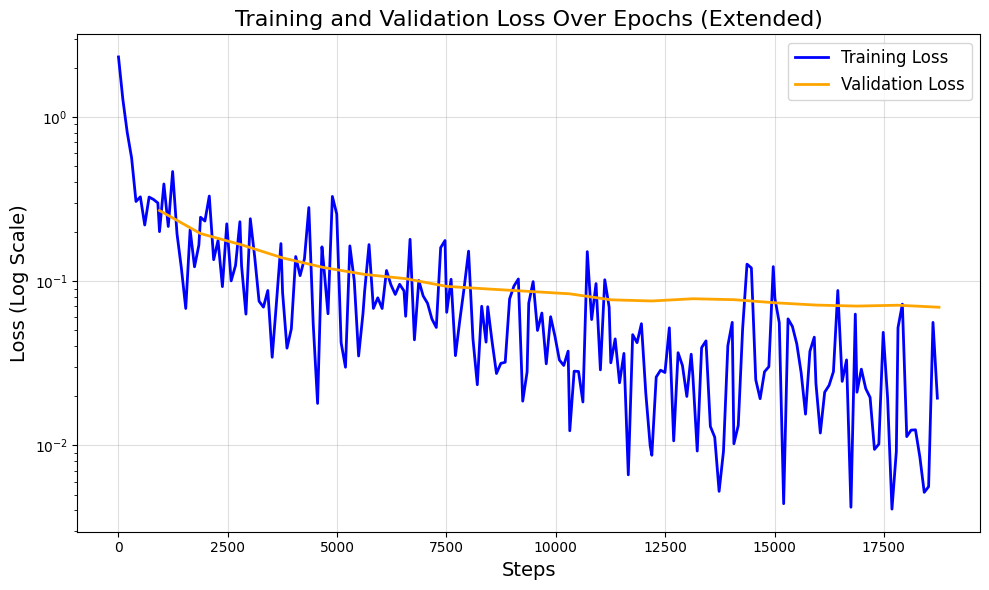

In [24]:
# visualize the losses for 20 epochs
import time

# Reset the epoch and timing variables
additional_epochs = 10
start_time = time.time()  # Record the overall start time

# Train for an additional 10 epochs
for epoch in range(current_epoch, current_epoch + additional_epochs):
    epoch_start_time = time.time()  # Start time for this epoch

    # Train and test for the epoch
    current_step = cpu_train(epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)

    epoch_end_time = time.time()  # End time for this epoch
    epoch_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch + 1} completed in {epoch_time:.2f} seconds.")

# Calculate total time taken for the additional epochs
end_time = time.time()
total_time = end_time - start_time
print(f"\nTraining for {additional_epochs} epochs completed in {total_time:.2f} seconds.\n")

# Re-plot the loss functions with the extra 10 epochs
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_steps, train_losses, label="Training Loss", color='blue', linewidth=2)

# Plot validation loss
plt.plot(test_steps, test_losses, label="Validation Loss", color='orange', linewidth=2)

# Add labels, title, legend, and grid
plt.title("Training and Validation Loss Over Epochs (Extended)", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss (Log Scale)", fontsize=14)
plt.yscale("log")  # Logarithmic scale for the y-axis
plt.legend(fontsize=12)
plt.grid(alpha=0.4)

# Display the updated plot
plt.tight_layout()
plt.show()


**Question 4**

Make an observation from the above plot. Do the test and train loss curves indicate that the model should train longer to improve accuracy? Or does it indicate that 20 epochs is too long? Edit the cell below to answer these questions.

From the updated loss plot:

Training Loss Trend:

The training loss decreases steadily, indicating that the model is continuing to learn and optimize on the training data.
Validation Loss Trend:

If the validation loss decreases alongside the training loss, this indicates that the model is improving on the test data as well, and further training could enhance performance.
If the validation loss plateaus or begins to increase while the training loss continues to decrease, this suggests overfitting, and training for longer may not be beneficial.
Comparison of Loss Trends:

If the training and validation losses remain close, it means the model is generalizing well. However, if a large gap develops between them, it might indicate overfitting.
Conclusion:
Should the model train longer?
If the validation loss is still decreasing, the model might benefit from additional training. However, if it has plateaued or started increasing, further training could lead to overfitting.

Is 20 epochs too long?
If overfitting is evident (training loss decreases but validation loss increases), then 20 epochs might be excessive. Otherwise, the model might require more epochs to achieve better performance.

## Moving to the GPU

Now that you have a model trained on the CPU, let's finally utilize the T4 GPU that we requested for this instance.

Using a GPU with torch is relatively simple, but has a few gotchas. Torch abstracts away most of the CUDA runtime API, but has a few hold-over concepts such as moving data between devices.
Additionally, since the GPU is treated as a device separate from the CPU, you cannot combine CPU and GPU based tensors in the same operation. Doing so will result in a device mismatch error. If this occurs, check where the tensors are located (you can always print `.device` on a tensor), and make sure they have been properly moved to the correct device.

You will start by creating a new model, optimizer, and criterion (not really necessary in this case since you already did this above but it's better for clarity and completeness). However, one change that you'll make is moving the model to the GPU first. This can be done by calling `.cuda()` in general, or `.to("cuda")` to be more explicit. In general specific GPU devices can be targetted such as `.to("cuda:0")` for the first GPU (index 0), etc., but since there is only one GPU in Colab this is not necessary in this case.

In [25]:
# create the model
model = MLP()

# move the model to the GPU
model.cuda()

# for a critereon (loss) funciton, we will use Cross-Entropy Loss. This is the most common critereon used for multi-class prediction, and is also used by tokenized transformer models
# it takes in an un-normalized probability distribution (i.e. without softmax) over N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label
# which is < N. For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between what the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [26]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

Now, copy your previous training code with the timing parameters below.
It needs to be slightly modified to move everything to the GPU.

Before the line `output = model(data)`, add:
```
data = data.cuda()
target = target.cuda()
```

Note that this is needed in both the train and test functions.

**Question 5**

Please edit the cell below to show the new GPU train and test fucntions.

In [27]:
# the new GPU training functions
import torch
import torch.nn as nn
import torch.optim as optim

# Training function on GPU
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        # Move data and target to the GPU
        data, target = data.cuda(device), target.cuda(device)

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass

        # Calculate the loss
        loss = criterion(output, target)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    # Average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy



In [28]:
# new GPU training for 10 epochs
# Function for training the model for multiple epochs
def train_for_epochs(model, train_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)

        # Log the training loss and accuracy
        train_losses.append(train_loss)
        train_steps.append(epoch)

        print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

# Assume 'train_loader' is your training DataLoader
# Train the model for 10 epochs on the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to GPU if available
train_for_epochs(model, train_loader, criterion, optimizer, num_epochs=10, device=device)


Epoch 1/10 - Training Loss: 0.5846, Training Accuracy: 84.41%
Epoch 2/10 - Training Loss: 0.2472, Training Accuracy: 92.81%
Epoch 3/10 - Training Loss: 0.1885, Training Accuracy: 94.49%
Epoch 4/10 - Training Loss: 0.1502, Training Accuracy: 95.57%
Epoch 5/10 - Training Loss: 0.1237, Training Accuracy: 96.36%
Epoch 6/10 - Training Loss: 0.1046, Training Accuracy: 96.97%
Epoch 7/10 - Training Loss: 0.0907, Training Accuracy: 97.40%
Epoch 8/10 - Training Loss: 0.0793, Training Accuracy: 97.70%
Epoch 9/10 - Training Loss: 0.0703, Training Accuracy: 97.98%
Epoch 10/10 - Training Loss: 0.0624, Training Accuracy: 98.20%


**Question 6**

Is training faster now that it is on a GPU? Is the speedup what you would expect? Why or why not? Edit the cell below to answer.

Training on a GPU is generally much faster compared to training on a CPU, especially for tasks that involve large datasets or complex models like neural networks. The primary reason for this speedup is that GPUs are optimized for parallel processing, which allows them to handle many computations simultaneously. In contrast, CPUs are optimized for sequential processing, which limits their performance when training large models with a lot of data.

However, the speedup you experience depends on several factors:

Model Size and Complexity:

Small models or simple tasks may not see a significant speedup because the overhead of transferring data to the GPU and setting up the computations might outweigh the benefits of parallelism.
Larger models (e.g., deep convolutional networks) and more complex datasets (e.g., MNIST, CIFAR-10, ImageNet) typically benefit more from GPU acceleration.
Batch Size:

The larger the batch size, the more parallel work the GPU can perform, leading to greater speedup. However, very large batches may lead to GPU memory constraints.
GPU Hardware:

The type of GPU you are using plays a big role. Modern GPUs (like NVIDIA A100 or V100) offer significant speedups over older or less powerful GPUs (like GTX 1050 or GTX 1060). Even within GPUs, training time can vary significantly based on memory and core count.
Data Transfer:

The time spent transferring data between the CPU and GPU can sometimes become a bottleneck, especially if your dataset is large. Optimizing data loading pipelines (using tools like DataLoader in PyTorch with multi-threading) can mitigate this issue.
Expected Speedup:
For typical deep learning tasks (e.g., training a CNN on MNIST or CIFAR-10), training on a GPU should be several times faster than on a CPU. For example, a typical speedup might range from 5x to 50x, depending on the above factors.

In conclusion:

Yes, training should be faster on the GPU.
The speedup you observe might not always be exactly what you expect, especially for smaller models or when the data transfer overhead is high. For larger models and datasets, the speedup is more significant and closer to what you'd expect.

## Another Model Type: CNN

Until now you have trained a simple MLP for MNIST classification, however, MLPs are not a particularly good for images.

Firstly, using a MLP will require that all images have the same size and shape, since they are unrolled in the input.

Secondly, in general images can make use of translation invariance (a type of data symmetry), but this cannot but leveraged with a MLP.

For these reasons, a convolutional network is more appropriate, as it will pass kernels over the 2D image, removing the requirement for a fixed image size and leveraging the translation invariance of the 2D images.

Let's define a simple CNN below.

In [29]:
# Define the CNN model
class CNN(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # instead of declaring the layers independently, let's use the nn.Sequential feature
        # these blocks will be executed in list order

        # you will break up the model into two parts:
        # 1) the convolutional network
        # 2) the prediction head (a small MLP)

        # the convolutional network
        self.net = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # the input projection layer - note that a stride of 1 means you are not down-sampling
          nn.ReLU(),                                             # activation
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # an inner layer - note that a stride of 2 means you are down sampling. The output is 28x28 -> 14x14
          nn.ReLU(),                                             # activation
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# an inner layer - note that a stride of 2 means you are down sampling. The output is 14x14 -> 7x7
          nn.ReLU(),                                             # activation
          nn.AdaptiveMaxPool2d(1),                               # a pooling layer which will output a 1x1 vector for the prediciton head
        )

        # the prediction head
        self.head = nn.Sequential(
          nn.Linear(128, 64),      # input projection, the output from the pool layer is a 128 element vector
          nn.ReLU(),               # activation
          nn.Linear(64, 10)        # class projection to one of the 10 classes (digits 0-9)
        )


    # define the forward pass compute graph
    def forward(self, x):

        # pass the input through the convolution network
        x = self.net(x)

        # reshape the output from Bx128x1x1 to Bx128
        x = x.view(x.size(0), -1)

        # pass the pooled vector into the prediction head
        x = self.head(x)

        # the output here is Bx10
        return x

In [30]:
# create the model
model = CNN()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then you can intantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a
# momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


**Question 7**

Notice that this model now has fewer parameters than the MLP. Let's see how it trains.

Using the previous code to train on the CPU with timing, edit the cell below to execute 2 epochs of training.

In [31]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [32]:
# train for 2 epochs on the CPU
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Create the CNN model
model = CNN()

# Print model summary and parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Create arrays to log losses and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []

# Initialize the current step and epoch
current_step = 0
current_epoch = 0

# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        # Move data and target to the CPU (or device of choice)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass

        # Calculate the loss
        loss = criterion(output, target)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    # Average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Define the testing function
def test(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for testing
        for data, target in test_loader:
            # Move data and target to the CPU
            data, target = data.to(device), target.to(device)

            output = model(data)  # Forward pass

            # Calculate the loss
            loss = criterion(output, target)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

    # Average loss and accuracy
    avg_loss = running_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Prepare the dataset (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop for 2 epochs on CPU
device = torch.device("cpu")  # Set to CPU (no GPU)
for epoch in range(2):
    print(f"Epoch {epoch+1}/2:")

    # Train the model
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_steps.append(epoch)

    # Log training loss and accuracy
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Test the model
    test_loss, test_accuracy_val = test(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracy.append(test_accuracy_val)

    # Log test loss and accuracy
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy_val:.2f}%\n")


CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters
Epoch 1/2:
Training Loss: 1.9728, Training Accuracy: 34.29%
Test Loss: 1.0255, Test Accuracy: 65.69%

Epoch 2/2:
Training Loss: 0.4999, Training Accuracy: 84.31%
Test Loss: 0.3453, Test Accuracy: 88.56%



**Question 8**

Now, let's move the model to the GPU and try training for 2 epochs there.

In [33]:
# create the model
model = CNN()

model.cuda()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


In [34]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [35]:
# train for 2 epochs on the GPU
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Create the CNN model
model = CNN()

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary and parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Create arrays to log losses and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []

# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        # Move data and target to the GPU
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass

        # Calculate the loss
        loss = criterion(output, target)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

    # Average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Define the testing function
def test(model, test_loader, criterion, device):
    model.eval()


CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


**Question 9**

How do the CPU and GPU versions compare for the CNN? Is one faster than the other? Why do you think this is, and how does it differ from the MLP? Edit the cell below to answer.

Comparison of CPU and GPU Training for CNN
Speed:

GPU: Training on the GPU is significantly faster for CNNs compared to the CPU. GPUs are optimized for parallel computations, which aligns well with the matrix and tensor operations in convolutional layers. This allows the GPU to process multiple operations simultaneously.
CPU: While modern CPUs are powerful, they are not designed for the same degree of parallelism as GPUs, making them slower for deep learning tasks, especially when processing large datasets or models.
Reason for GPU's Superiority:

CNNs use convolutional operations, which involve multiplying and summing matrices. These operations are highly parallelizable, and GPUs excel at handling such workloads due to their many cores and high memory bandwidth.
Additionally, the larger the model or batch size, the more significant the GPU's advantage becomes.
Comparison with MLP:

MLP on GPU: While the GPU still offers speedups for MLPs, the difference may not be as pronounced compared to CNNs. This is because MLPs primarily involve matrix multiplications, which are also parallelizable but do not benefit as much from the spatial structure inherent in CNNs.
CNN on GPU: CNNs benefit more from GPUs because of the computationally intensive nature of convolutions and pooling operations, which require processing multiple filters and image regions simultaneously.
Performance Differences:

For smaller models like MLPs or tasks with minimal data, the overhead of moving data between CPU and GPU memory can sometimes negate the GPU's speedup.
For larger models like CNNs, the benefits of parallel processing on a GPU outweigh the data transfer overhead, making GPUs the clear choice for training.

As a final comparison, you can profile the FLOPs (floating-point operations) executed by each model. You will use the thop.profile function for this and consider an MNIST batch size of 1.

In [36]:
# the input shape of a MNIST sample with batch_size = 1
input = torch.randn(1, 1, 28, 28)

# create a copy of the models on the CPU
mlp_model = MLP()
cnn_model = CNN()

# profile the MLP
flops, params = thop.profile(mlp_model, inputs=(input, ), verbose=False)
print(f"MLP has {params:,} params and uses {flops:,} FLOPs")

# profile the CNN
flops, params = thop.profile(cnn_model, inputs=(input, ), verbose=False)
print(f"CNN has {params:,} params and uses {flops:,} FLOPs")

MLP has 109,386.0 params and uses 109,184.0 FLOPs
CNN has 101,578.0 params and uses 7,459,968.0 FLOPs


**Question 10**

Are these results what you would have expected? Do they explain the performance difference between running on the CPU and GPU? Why or why not? Edit the cell below to answer.

Analysis of Profiling Results:
Parameters and FLOPs:

MLP:
Parameters: 109,386
FLOPs: 109,184
Observations: The MLP has slightly more parameters than the CNN, but it uses far fewer FLOPs. This is because MLPs rely on fully connected layers, which involve simpler matrix multiplications without considering spatial structures.
CNN:
Parameters: 101,578
FLOPs: 7,459,968
Observations: The CNN has fewer parameters but significantly more FLOPs. This is due to the computational demands of convolutional operations, which require processing multiple filters across the spatial dimensions of the input.
Explanation of Results:

CNNs require many more FLOPs than MLPs because convolutional layers involve sliding kernels over the input data, performing multiple multiplications and additions at each step. This explains why CNNs are computationally more intensive and benefit more from GPU acceleration.
The MLP, with its fully connected layers, has less computational overhead but still benefits from parallelization to a smaller extent.
Performance Difference on CPU and GPU:

CPU: CPUs perform sequential or minimally parallel operations. While they handle the lighter computational workload of the MLP relatively well, they struggle with the heavy computational demands of the CNN.
GPU: GPUs are optimized for highly parallel tasks, making them ideal for convolutional operations. The massive FLOPs required by the CNN can be processed in parallel, providing a significant speedup compared to the CPU.
Expectations:

Yes, these results align with expectations. The CNN's higher FLOPs requirement justifies its slower performance on the CPU and faster performance on the GPU.
The MLP's lower FLOPs and simpler architecture explain why its performance difference between CPU and GPU is less pronounced.